<a href="https://colab.research.google.com/github/Zeko2005/cap-comp215/blob/main/Project2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Project2: Langton's Ant
Name: Ziad Elbadry

Last Updated: 4/1/2024

In [2]:
%matplotlib inline

import time
from pprint import pprint

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import animation
from scipy.signal import correlate2d
import random
from timeit import timeit

# Configure matplotlib's animation library to work in the browser.
matplotlib.rc('animation', html='jshtml')

In [3]:
tab20_mod = matplotlib.colormaps['tab20']
tab20_mod.colors = ((1,1,1,1), *tab20_mod.colors[1:])

def plot_2d_array(array, axes=None, title='', cmap=tab20_mod, **options):
    """
    Plot the 2D array as an image on the given axes  1's will be dark blue, 0's will be light blue.

    :param axes: the axes to plot on, or None to use the `plt.gca()` (current axes)
    :param options: keyword arguments passed directly to `plt.imshow()`
           see https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html
    """
    axes = axes or plt.gca()  # If not axes are provided, draw on current axes
    axes.set_title(title)
    # Turn off axes labels and tick marks
    axes.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False ,
                     labelbottom=False, labeltop=False, labelleft=False, labelright=False,)
    # Defaults for displaying a "matrix" with hard-pixel boundaries and (0,0) at top-left
    options = {**dict(interpolation='nearest', origin='upper'), **options}
    axes.imshow(array, cmap=cmap, **options)

In [4]:
class Animation2D:
    """
      Animates any 2D model with a step() method and a draw() method, using matplotlib
      model.step() should take no parameters - just step the model forward one step.
      model.draw() should take 2 parameters, the matpltolib axes to draw on and an integer step number

      See https://www.allendowney.com/blog/2019/07/25/matplotlib-animation-in-jupyter/
          for a discussion of the pros and cons of various animation techniques in jupyter notebooks
    """

    def __init__(self, model, frames=50, steps_per_frame=1, figsize=(8, 8)):
        """
        :param model: the simulation object to animate, with step() and draw(axes, step) methods
        :param frames: number of animation frames to generate
        """
        self.model = model
        self.frames = frames
        self.steps_per_frame = steps_per_frame
        self.fig, self.ax = plt.subplots(figsize=figsize)

    def animation_step(self, step):
        """ Step the model forward and draw the plot """
        if step > 0:
            for _ in range(self.steps_per_frame):
                self.model.step()
        self.model.draw(self.ax, step=step * self.steps_per_frame)

    def show(self):
        """ return the matplotlib animation object, ready for display """
        anim = animation.FuncAnimation(self.fig, self.animation_step, frames=self.frames)
        plt.close()  # this ensures the last frame is not shown as a separate plot
        return anim

    def animate(self, interval=None):
        """ Animate the model simulation directly in the notebook display block """
        from IPython.display import clear_output
        try:
            for i in range(self.frames):
                clear_output(wait=True)  # clear the IPython display
                self.ax.clear()  # clear old image from the axes (fixes a performance issue)
                plt.figure(self.fig)  # add the figure back to pyplot ** sigh **
                self.animation_step(i)
                plt.show()  # show the current animation frame (pyplot then closes and throws away figure ** sigh **)
                if interval:
                    time.sleep(interval)
        except KeyboardInterrupt:
            pass

In [5]:
mat = np.array([1,2])
mat[(0)]

1

##Making an ant class

In [6]:
class Ant:
    """ 2D Cellular Automaton that simulates an Ant digging and undigging the ground """
    # Defines directions and the states of the cells
    NOTDUG = 0
    DUG = 1
    RIGHT = np.array([0,1])
    LEFT = np.array([0,-1])
    UP = np.array([-1,0])
    DOWN = np.array([1,0])
    DIRECTIONS = [RIGHT,UP,LEFT,DOWN]

    # Define a colour map that maps each cell state to an intuitive colour.
    cmap = [(1, 1, 1), (0, 0, 0)]
    cmap[NOTDUG] = (1, 1, 1)  # white
    cmap[DUG] = (0, 0, 0)  # black
    ground_colour_map = matplotlib.colors.ListedColormap(cmap)



    def __init__(self, n, q=0.8):
        """Initializes the model.
        n: number of rows and columns, coordinate specifies where the ant spawns
        , direction is where the ant is facing, state is the ground
        """
        self.dim = n
        self.coordinate = np.array([int(self.dim/2), int(self.dim/2)])
        self.direction = self.RIGHT
        self.state = np.zeros((self.dim, self.dim))

    def step(self):
        """Executes one time step, applying the CA rules to move the ant and turn it."""
        self.edges()
        self.coordinate = self.coordinate + self.direction
        self.state[tuple(self.coordinate)] = (self.state[tuple(self.coordinate)] + 1) % 2
        self.turn()

    def edges(self):
        if self.coordinate[(1)] == self.dim - 1:
          self.direction = self.LEFT
        elif self.coordinate[(1)] == 0:
          self.direction = self.RIGHT
        elif self.coordinate[(0)] == self.dim - 1:
          self.direction = self.UP
        elif self.coordinate[(0)] == 0:
          self.direction = self.DOWN

    def turn(self, p=0.5):
      """Changes the direction of the ant with a probability p."""
      # This code was modified by AI because I faced some errors but I came up with the basic idea

      for i, direction in enumerate(self.DIRECTIONS):
        if np.array_equal(self.direction, direction):
          new_index = (i + 1) % len(self.DIRECTIONS)
          break  # Exit the loop after finding the match

      # Optional: Handle cases where self.direction doesn't match any in DIRECTIONS
      # (This might indicate an error or unexpected state)

      if p >= random.random():
        self.direction = self.DIRECTIONS[new_index]
      else:
        new_index = (new_index - 1) % len(self.DIRECTIONS)
        self.direction = self.DIRECTIONS[new_index]

    def draw(self, axes=None, step=''):
        """Draws the CA cells using the ground colour map so values are coloured intuitively."""
        axes = axes or plt.gca()
        title = f'Ant Land:{step}'
        plot_2d_array(self.state, axes=axes, title=title,
                      cmap=self.ground_colour_map, vmin=0, vmax=len(self.ground_colour_map.colors))

In [7]:
def make_ants():
    """ Return new ants """
    ant_model = Ant(100)
    return ant_model

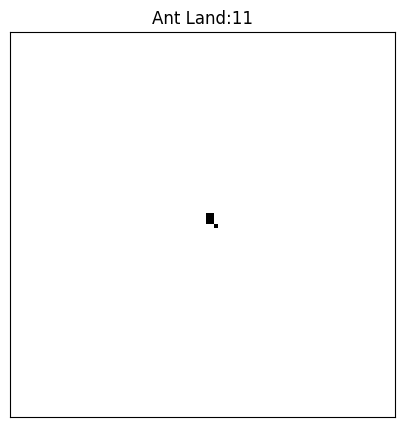

In [8]:
ant1 = Ant(100)
animated = Animation2D(ant1, frames = 1500, figsize=(5, 5))
animated.animate(interval=0.3)

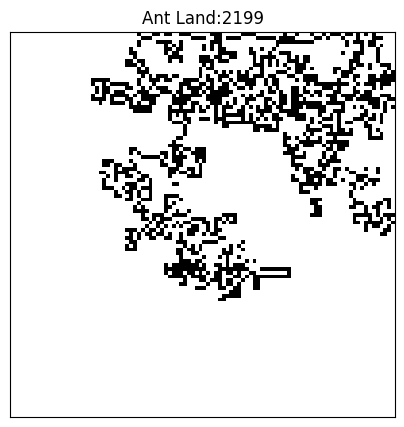

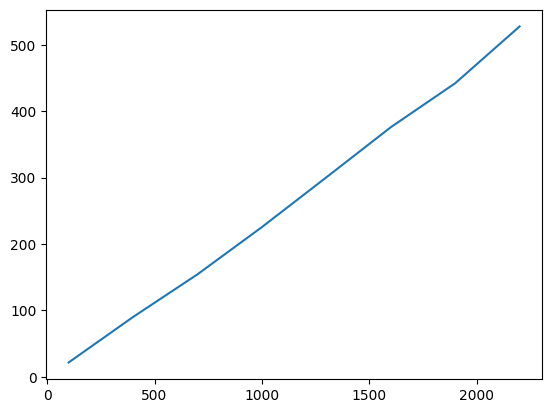

In [9]:
# Ex. 1 your code here...
xseries = [100, 400, 700, 1000, 1300, 1600, 1900, 2200]
yseries = []


for i in xseries:
  ants = make_ants()
  animated = Animation2D(ants, frames = i, figsize=(5, 5))
  yseries.append((timeit(lambda: animated.animate(),  number=3))/3)

plt.plot(xseries, yseries)

The process is linear